# Classifier training

## Loading libraries and requirements

In [ ]:
!pip install datasets

In [ ]:
!pip install tensorboard

In [ ]:
## Standard libraries
import os
from copy import deepcopy
from torch.utils.data import Subset
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader

import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Import tensorboard
%load_ext tensorboard


from datasets import load_dataset


# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/drive/MyDrive/ms_nist/brain"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report




<ipython-input-3-53e5274364bf>:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<Figure size 640x480 with 0 Axes>

## SimCLR loading and embeddings generation 

In [5]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=200):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

In [ ]:
from datasets import load_dataset


ds3= load_dataset("youngp5/BrainMRI")


In [ ]:
ds3

In [9]:
model = SimCLR.load_from_checkpoint(
    checkpoint_path="/content/drive/MyDrive/ms_nist/brain/brain/lightning_logs/version_43/checkpoints/epoch=198-step=7363.ckpt",
      batch_size=512,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=200
)

In [ ]:

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

resize_transform = transforms.Resize((128, 128))
grayscale=transforms.Grayscale(num_output_channels=3)
def resize_example(example):
    
    example['image'] = grayscale(example['image'])
    example['image'] = resize_transform(example['image'])
    return example



ds3 = ds3.map(resize_example)


In [15]:
class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset,transform):
        self.dataset = dataset
        self.transform = transform



    def __getitem__(self, idx):
        img = self.dataset[idx]['image']
        img = self.transform(img)
        label = self.dataset[idx]['label']


        return img, label

    def __len__(self):
        return len(self.dataset)

In [16]:
ds3 = ds3['train'].train_test_split(test_size=0.2)
ds3_m=ds3['test'].train_test_split(test_size=0.5)


In [17]:
ds3_t = ds3['train']
ds3_m=ds3['test'].train_test_split(test_size=0.5)

In [18]:
simclr_dataset = SimCLRDataset(ds3['train'], img_transforms)

In [ ]:
ds3_m

In [20]:
ds3_train = SimCLRDataset(ds3['train'], img_transforms)

In [21]:
ds3_test=SimCLRDataset(ds3_m['test'], img_transforms)
ds3_val=SimCLRDataset(ds3_m['train'], img_transforms)



In [22]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()


    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):

        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

In [ ]:
train_feats_simclr = prepare_data_features(model, ds3_train)
test_feats_simclr = prepare_data_features(model, ds3_test)
val_feats_simclr = prepare_data_features(model, ds3_val)

In [24]:
len(train_feats_simclr[1][0])

512

In [25]:
train_feats_simclr[1][1]

tensor(0)

## Classifier training

In [ ]:
class CosineMLPClassifier(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100,
                 hidden_dims=[512,128], dropout=0.3, activation="relu"):
        super().__init__()
        self.save_hyperparameters()

        act_layer = {
            "relu": nn.ReLU(),
            "gelu": nn.GELU(),
            "silu": nn.SiLU()
        }[activation.lower()]

        layers = []
        input_dim = feature_dim
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(input_dim, dim),
                nn.BatchNorm1d(dim),
                act_layer,
                nn.Dropout(dropout)
            ])
            input_dim = dim

        self.encoder = nn.Sequential(*layers)
        self.encoder.apply(self.init_weights)
        # Cosine classifier
        self.classifier = nn.Linear(input_dim, num_classes, bias=False)
        self.scale = nn.Parameter(torch.tensor(10.0))  

    def forward(self, x):
        x = self.encoder(x)

        
        x_norm = F.normalize(x, dim=1)
        w_norm = F.normalize(self.classifier.weight, dim=1)
        logits = self.scale * torch.matmul(x_norm, w_norm.T)  
        return logits

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[
                int(self.hparams.max_epochs * 0.6),
                int(self.hparams.max_epochs * 0.8)
            ],
            gamma=0.1
        )
        return [optimizer], [scheduler]


    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)


    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self(feats)
        loss= F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(f"{mode}_loss", loss,on_epoch=True,on_step=False, prog_bar=True)
        self.log(f"{mode}_acc", acc,on_epoch=True,on_step=False, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')


In [ ]:

early_stop_callback = EarlyStopping(
    monitor="val_loss",     
    patience=50,                
    mode="min",             
    verbose=True
)

In [ ]:
def train_classifier(batch_size, train_feats_data, test_feats_data,val_feats_data,  max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "MLPRegression7"),
                         accelerator="auto",
                         devices=1,log_every_n_steps=1,gradient_clip_val=1.0,
                         max_epochs=max_epochs,
                         callbacks=[early_stop_callback,ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=True,
                         check_val_every_n_epoch=1)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=8)
    val_loader = data.DataLoader(val_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=8)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=8)

    

    pl.seed_everything(42)  # To be reproducable
    model = CosineMLPClassifier(**kwargs)
    trainer.fit(model, train_loader, val_loader)
    model = CosineMLPClassifier.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

In [ ]:
results = {}

_, eval = train_classifier(batch_size=256,
                                        train_feats_data=train_feats_simclr,
                                        test_feats_data=test_feats_simclr,val_feats_data=val_feats_simclr,

                                        feature_dim=train_feats_simclr.tensors[0].shape[1],
                                        num_classes=3,
                                        lr=5e-4,
                                        weight_decay=1e-3,max_epochs=150)
results["1"] = eval

## Model evaluation

In [29]:
results["1"]

{'train': 0.9999999403953552, 'test': 0.9945578575134277}

In [ ]:


def get_preds_and_labels(model, dataloader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            feats, labels = batch


            outputs = model(feats)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_preds), torch.cat(all_labels)


In [32]:
test_loader = data.DataLoader(test_feats_simclr, batch_size=256, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=4)
y_pred, y_true = get_preds_and_labels(_, test_loader)


100%|██████████| 3/3 [00:00<00:00,  6.64it/s]


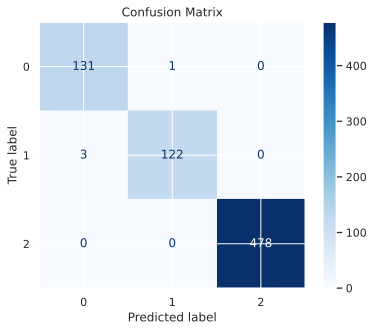

In [ ]:

import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [34]:
report=classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       132
           1       0.99      0.98      0.98       125
           2       1.00      1.00      1.00       478

    accuracy                           0.99       735
   macro avg       0.99      0.99      0.99       735
weighted avg       0.99      0.99      0.99       735

